In [9]:
import pandas as pd
import numpy as np
import yfinance as yf
from pandas_datareader import data as pdr
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn
import statsmodels.api as sm


start = "2017-1-1"
symbols_list = ['AMZN', 'AAL']

In [16]:
import matplotlib as mpl

In [15]:
matplotlib.__version__

'3.3.4'

In [119]:
start_date = datetime(2020, 1, 1)
end_date = datetime(2021, 1, 1)
  
# get the data
data = yf.download('AMZN')

[*********************100%***********************]  1 of 1 completed


In [120]:
data = data.reset_index()
data = data[['Date', 'Close']]

<AxesSubplot:>

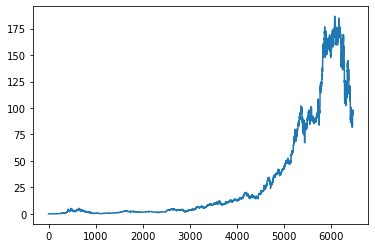

In [121]:
data['Close'].plot()

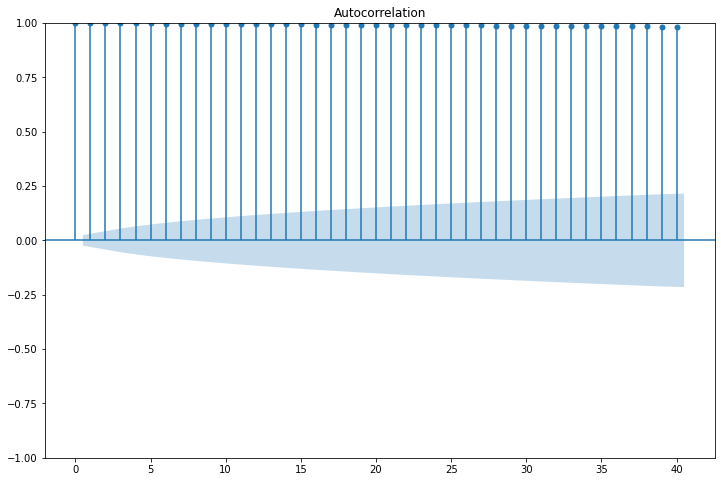

In [122]:
with mpl.rc_context():
    mpl.rc("figure", figsize=(12, 8))
    sm.graphics.tsa.plot_acf(data['Close'], lags = 40)

## Time Series Analysis 

It definitely appears to have a trend in the time series. Before we explore the autocorellation in the time series data we have to make sure that we detrend the time series. This means that we need to make sure that our time series is stationary before we explore the auto-correlation.


In general time series are composed by three different components:

1) Trend: is the overall change over time, e.g. steady growth or decline in values. An example for the trend is the constantly growing energy consumptions in most countries.

2) The Seasonality: is the results of seasonal effects i.e., regularly recurring effects that lead to an increase or decrease with respect to the general trend.

3) The autocorrelation between observations R_t. The Autocorrelation models how the value at time t depends on the prior values, i.e., how x_t is correlated with x_{t-1}, x_{t-2}. The autocorrelation models the changes in time series that are not explained by the trens or seasonality.

So, before we start exploring autocorrelation we need to make sure that our time series are stationary.

ADF test is used to determine the presence of unit root in the series. and thus help us understand if the ts is stationary or not. 

- Null hypothesis: The series has a unit root
- Alternative Hypothesis: The series has no unit root.

If we fail to reject the null hypothesis, the test may provide evidence that the series is not stationary.




In [123]:
from statsmodels.tsa.stattools import adfuller

def adf_test(ts):
    print('Results of Dickey - Fuller test:')
    dftest = adfuller(ts, autolag = 'AIC')
    dfoutput = pd.Series(dftest[0:4], 
                         index = [
                             'Test Statistic',
                             'p-value',
                             '# of Lags',
                             '# of Obs used'])
    for key, value in dftest[4].items():
        dfoutput["Critical Value (%s)" % key] = value
        
    print(dfoutput)

ts = data['Close']
adf_test(ts)

Results of Dickey - Fuller test:
Test Statistic            -0.505672
p-value                    0.890905
# of Lags                 34.000000
# of Obs used           6429.000000
Critical Value (1%)       -3.431368
Critical Value (5%)       -2.861990
Critical Value (10%)      -2.567009
dtype: float64


Base on the p-value, we cannot reject the null hypothesis. So, our series is not stationary. Let's now try to convert the ts to stationary by applying differencing.


<AxesSubplot:>

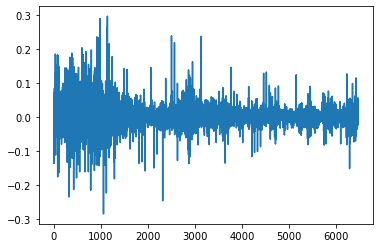

In [124]:
data['logClose'] = np.log(data['Close'])
data['logCloseDiff'] = data['logClose'] - data['logClose'].shift(1)
data['logCloseDiff'].dropna().plot()
 

In [125]:
adf_test(data['logCloseDiff'].dropna())

Results of Dickey - Fuller test:
Test Statistic         -1.366847e+01
p-value                 1.475142e-25
# of Lags               3.300000e+01
# of Obs used           6.429000e+03
Critical Value (1%)    -3.431368e+00
Critical Value (5%)    -2.861990e+00
Critical Value (10%)   -2.567009e+00
dtype: float64


# Correlogram

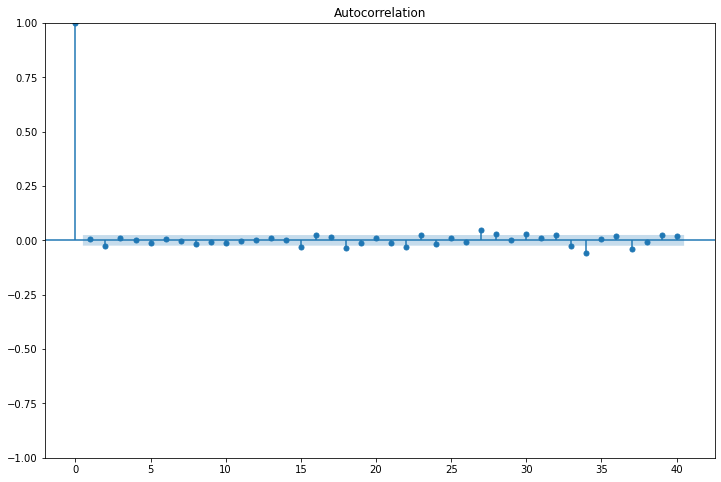

In [126]:
with mpl.rc_context():
    mpl.rc("figure", figsize=(12, 8))
    sm.graphics.tsa.plot_acf(data['logCloseDiff'].dropna(), lags = 40)

From the above correlogram, it appears that there are a few peaks. 

## Fit an AR(p) model and Use AIC to identify optiomal p

To identify the optimal order of the model we use the Akaike Information critetion (AIC). Our goal is to identify p tha minimizes the AIC $AIC = -\frac{2}{T} ln(likelihood) + p \frac{2}{T}$, where $p$ is the number of parameters and $T$ is the sample size.

In [127]:
from statsmodels.tsa.ar_model import AutoReg, ar_select_order

In [128]:
#AIC = float('inf')
#p = None
#for i in range(40):
#    mod = AutoReg(data['CloseDiff'].dropna(), i, old_names=False)
#    res = mod.fit()
#    if AIC > res.aic:
#        AIC = res.aic
#        p = i
        
mod = AutoReg(data['logCloseDiff'].dropna(), 7)
res = mod.fit()
print(res.summary())

                            AutoReg Model Results                             
Dep. Variable:           logCloseDiff   No. Observations:                 6463
Model:                     AutoReg(7)   Log Likelihood               12373.707
Method:               Conditional MLE   S.D. of innovations              0.036
Date:                Sat, 21 Jan 2023   AIC                         -24729.413
Time:                        11:32:31   BIC                         -24668.459
Sample:                             7   HQIC                        -24708.324
                                 6463                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.0011      0.000      2.519      0.012       0.000       0.002
logCloseDiff.L1     0.0046      0.012      0.372      0.710      -0.020       0.029
logCloseDiff.L2    -0.0254      

/Users/petros-pavlosypsilantis/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


## Model Checking

To check whether the model we fit is adequate to describe all the autocorrelation in the time series we check whether the residuals behave as white noise. White noise is when there is no correlation in the residuals.

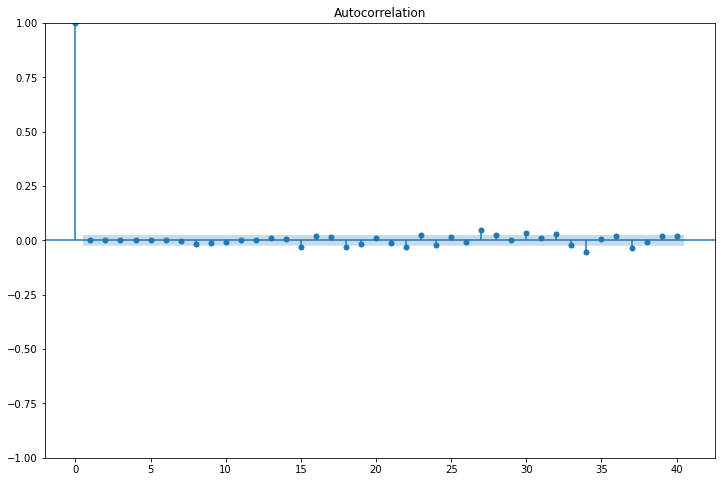

In [129]:
with mpl.rc_context():
    mpl.rc("figure", figsize=(12, 8))
    sm.graphics.tsa.plot_acf(res.resid, lags = 40)

We can see some peaks in the correlogram of the residuals which indicates that the our AR(p)
model is not adequate enough to capture all the autocorrelation. We can also use the Ljung - Box statistic to check the closenes of the residualts to white noise.

In [130]:
sm.stats.acorr_ljungbox(res.resid, lags = range(1,30),return_df=True)


,lb_stat,lb_pvalue
1,0.000168,0.989656
2,0.001435,0.999283
3,0.001451,0.999985
4,0.003921,0.999998
5,0.004661,1.000000
6,0.004662,1.000000
7,0.008981,1.000000
8,1.938965,0.982826
9,2.623115,0.977387
10,3.235753,0.975319


It appears that AR model is capable of explaining away some of the autocorrelation in the residuals of the first order difference daily log ref prices but it appears that the effect of volatilty clustering (See the plot of the log returns above) and long memory effects cannot be account and therefore one may need high order model to adequately describe the dynamic structure of he data.

## ARMA and ARIMA

The moving average model AM is a linear combination of the past white noise terms. Intuitevely, this means that the MA model sees such random white noise shocks directly at each current value of the model. This is in contrast to an AR(p) model where the white noise shocks are only seen indirectly via regression onto previous terms of the series. MA models are always weekly stationary because they are finite linear combinations of a white noise sequence for which the first two moments are time invariant.

MA(1): $r_{t} = c_{0} + a_{t} - \theta_{1}a_{t-1}$

ARMA model combine AR and MA, with AR to consider its own past behavious as input and as such trying to capture market participants behaviour, such as momentum and mean reversion in stock trading. The latter MA model is used to characterise shock information to a series such as surprise earning anouncements or unexpected events (e.g. BP Deepwater horizon). So, ARMA attemtps to capture both these scenarios.

ARMA(p, q): $r_t = \phi_{0} + \sum_{i}^{p} \phi_{i=1} r_{t-i} + a_{t} - \sum_{j=1}^{q} \theta_{j} a_{t-j}$